<a href="https://colab.research.google.com/github/langemittbacken/D7047E_labs/blob/main/lab3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split
import numpy

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
data = torchvision.datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 100549016.64it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 41049032.13it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25639007.03it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5483744.61it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_size = int(0.9*len(data))
test_size = len(data) - train_size
train_set, val_set = torch.utils.data.random_split(data, [train_size,test_size])

BATCH_SIZE = 1000
SHUFFLE = True
LEARNING_RATE = 1e-3  

train_loader = DataLoader(train_set, batch_size= BATCH_SIZE, shuffle= SHUFFLE )
test_loader = DataLoader(test_data, batch_size= BATCH_SIZE, shuffle= SHUFFLE)
val_loader = DataLoader(val_set, batch_size= BATCH_SIZE, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(4*4*32, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def featureExtract(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = torch.flatten(x, 1)
        return x

# Implement a train model function so you can re_use it in task 3 and 4. 
# Should return the best performing model after training
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, msg, pretrained):
    best_accuracy = 0
    writer = SummaryWriter()
    for epochs in range(num_epochs):
        for batch_nr, (data, labels) in enumerate(train_loader):
         
            prediction = model.forward(data)
            labels = labels%10
            loss = criterion(prediction, labels)

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()
            writer.add_scalar(msg, loss, epochs)
            print(
            f'\rEpoch {epochs+1} [{batch_nr+1}/{len(train_loader)}] - Loss: {loss}',
            end=''
        )
        val_accuracy = 0
        total = 0
        with torch.no_grad():
            for batch_nr, (data, labels) in enumerate(val_loader):
                labels = labels%10
                prediction = model.forward(data)
                _, predicted = torch.max(prediction, 1)
                val_accuracy += (predicted == labels).sum().item()
                total += labels.size(0)
            print(" ",val_accuracy/total, "Val Acc")
            val_accuracy = val_accuracy/total
            if(best_accuracy < val_accuracy and pretrained == False):
                best_accuracy = val_accuracy
                print("best model here")
                torch.save(model.state_dict(), "./E2")


def test_model(model, test_loader):
    test_accuracy = 0
    total = 0
    predictList = []
    testList = []
    testEmbed = []

    test_embeddings = torch.zeros((1000, 512), dtype=torch.float32)
    
    for batch_nr, (data, labels) in enumerate(test_loader):
        labels = labels%10
        a = model.featureExtract(data)
        print(a.shape)
        testEmbed.append(a)
        prediction = model.forward(data)
        _, predicted = torch.max(prediction, 1)
        for i in range(len(prediction)):
            predictList.append(predicted[i].item())
            testList.append(labels[i].item())
        test_accuracy += (predicted == labels).sum().item()
        total += labels.size(0)
    print(test_accuracy/total, "Test Accuracy")
  

# Hyperparams. Set these to reasonable values
LEARNING_RATE = 1e-3

# Load our network
model = Net()

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer

optimizer = optim.Adam(model.parameters(), LEARNING_RATE)

# Train the model
msg = "trainloss leaky relu and adam"
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, 10, msg, pretrained=False)

# Test the model
model.load_state_dict(torch.load("./E2"))
tested_model = test_model(model, test_loader)

Epoch 1 [54/54] - Loss: 0.27203652262687683  0.9175 Val Acc
best model here
Epoch 2 [54/54] - Loss: 0.1586388498544693  0.9573333333333334 Val Acc
best model here
Epoch 3 [54/54] - Loss: 0.0657772496342659  0.97 Val Acc
best model here
Epoch 4 [54/54] - Loss: 0.06522849202156067  0.9755 Val Acc
best model here
Epoch 5 [54/54] - Loss: 0.061915021389722824  0.979 Val Acc
best model here
Epoch 6 [54/54] - Loss: 0.032153379172086716  0.9825 Val Acc
best model here
Epoch 7 [54/54] - Loss: 0.03239407762885094  0.9818333333333333 Val Acc
Epoch 8 [54/54] - Loss: 0.03870980069041252  0.9846666666666667 Val Acc
best model here
Epoch 9 [54/54] - Loss: 0.0334937646985054  0.985 Val Acc
best model here
Epoch 10 [54/54] - Loss: 0.042081400752067566  0.9845 Val Acc
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])
torch.Size([1000, 512])

In [ ]:
testEmbed = []
labelList = []
a = None
def test_model(model, test_loader):
    test_accuracy = 0
    total = 0
    predictList = []
    testList = []
    

    test_embeddings = torch.zeros((1000, 512), dtype=torch.float32)
    
    for batch_nr, (data, labels) in enumerate(test_loader):
        labelList.append(labels.numpy())
        labels = labels%10
        extracted = model.featureExtract(data)
        test_embeddings = torch.cat((test_embeddings, extracted), 1)
        testEmbed.append(extracted)
        prediction = model.forward(data)
        _, predicted = torch.max(prediction, 1)
        for i in range(len(prediction)):
            predictList.append(predicted[i].item())
            testList.append(labels[i].item())
        test_accuracy += (predicted == labels).sum().item()
        total += labels.size(0)
    print(test_accuracy/total, "Test Accuracy")
    a = test_embeddings
tested_model = test_model(model, test_loader)

0.9892 Test Accuracy


In [ ]:
t = torch.stack(testEmbed)
t = t.detach().numpy()

#testEmbed



concatenated_tensor = torch.cat(testEmbed, dim=0)

print(concatenated_tensor.shape)  # Output: torch.Size([50, 3])
conc= np.array(labelList).flatten()

conc

torch.Size([10000, 512])


array([9, 9, 3, ..., 9, 7, 8])

In [ ]:
tsne = TSNE(2)
tsne_proj = tsne.fit_transform(concatenated_tensor.detach().numpy())

pca = PCA(n_components=2)
pca_proj = pca.fit_transform(concatenated_tensor.detach().numpy())

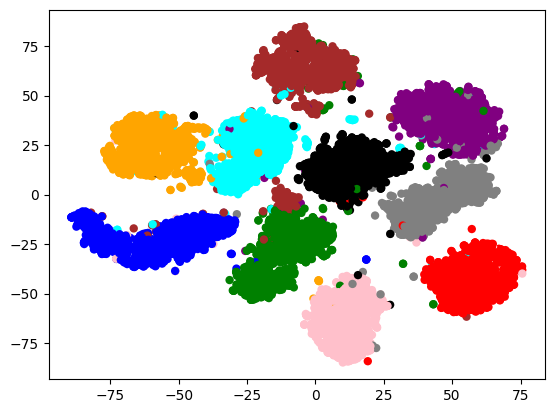

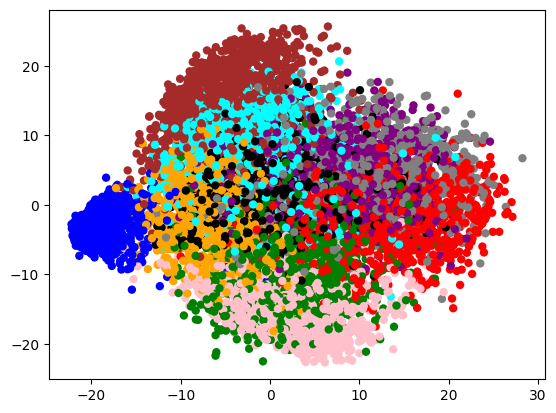

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



def plot(features, labels):
    colorList = ['red', 'blue', 'green', 'purple', 'orange', 'gray', 'pink', 'brown', 'black', 'cyan']
    colors = [colorList[label] for label in labels]

    plt.scatter(features[:,0], features[:,1], c=colors, linewidths=0.01)
    plt.show()

plot(tsne_proj, conc)
plot(pca_proj, conc)

In [ ]:
print("ok")

ok
